# Image Colorization using Optimization

## Imports

In [1]:
%matplotlib inline

import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Load Image

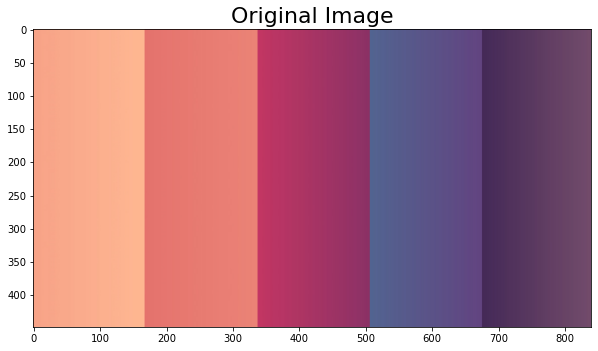

In [2]:
orig_img = cv2.cvtColor(cv2.imread("images/gradients.jpg"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Original Image", {'fontsize':22})
plt.imshow(orig_img)

## Convert to Grayscale

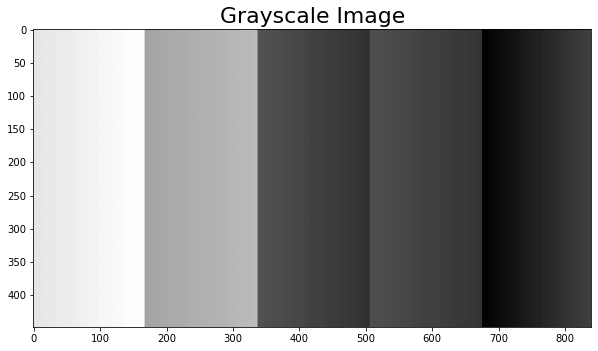

In [3]:
grayscale_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10, 10))
plt.title("Grayscale Image", {'fontsize':22})
plt.imshow(grayscale_img, cmap='gray')

## UI: Image Colorization Setup

### Step 1: Choose a color

In [39]:
from IPython import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='black',
    disabled=False
)
display.display(color_picker)

ColorPicker(value='black', description='Pick a color')

### Step 2: Place Markings

If it doesn't get you to the drawing mode, then rerun this function again.

============================================   NOTICE   ============================================

You do not need to rerun this cell or the last to add another color!
Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.


<IPython.core.display.Javascript object>


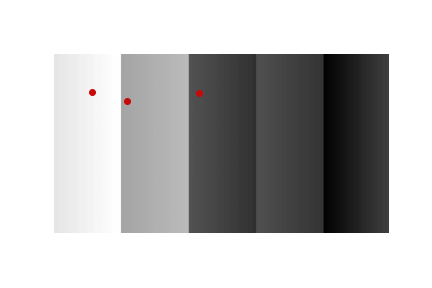

In [42]:
%matplotlib notebook

my_color = color_picker.value

def mark_image(img):
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    print("\n============================================   NOTICE   ============================================\n")
    print("You do not need to rerun this cell or the last to add another color!")
    print("Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.")
    fig = plt.figure()
    fig.set_label('Mark the spots to color')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plot_points = []

    def on_mouse_pressed(event):
        my_color = color_picker.value
        x = event.xdata
        y = event.ydata
        plot_points.append((x, y, my_color))
        plt.plot(x, y, c=my_color, marker='o')
        
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)

    return plot_points

plot_points = mark_image(grayscale_img)

### Step 3: Add Markings to grayscale image

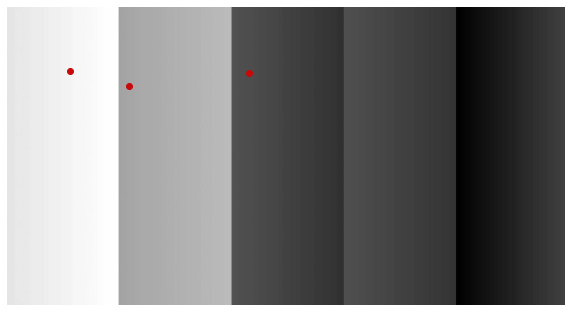

In [44]:
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
for pt in plot_points:
    x, y, color = pt
    plt.plot(x, y, c=color, marker='o')
plt.savefig("output/marked_img.jpg", bbox_inches='tight', pad_inches=0, dpi=500)
marked_img = cv2.cvtColor(cv2.imread("output/marked_img.jpg"), cv2.COLOR_BGR2RGB)

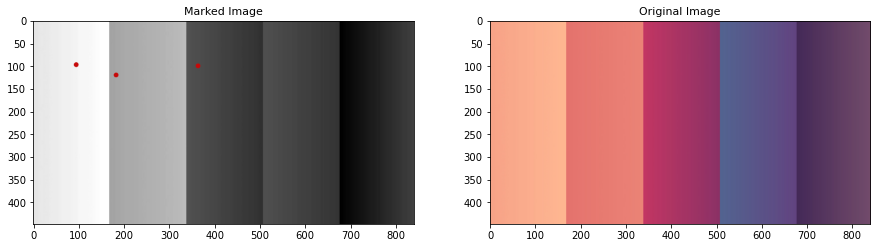

In [59]:
marked_img = cv2.resize(marked_img, (orig_img.shape[1], orig_img.shape[0]))

fig = plt.figure(figsize=(15, 15))
plt.subplot(122)
plt.title("Original Image", {'fontsize':11})
plt.imshow(orig_img)

plt.subplot(121)
plt.title("Marked Image", {'fontsize':11})
plt.imshow(marked_img)